# W8 Homework Assignment 7
### SVMs, kNN, and Random Forest for handwritting recognition for handwriting recognition
Syracuse Applied Data Science, IST-707 Data Analytics  

Ryan Timbrook (RTIMBROO)  
DATE: 8/28/2019
ASSIGNMENT: Homework 7


## 1. Introduction
**-------------------------------------------------------------------------------------------------**  
Recognize digits 0 to 9 in handwriting images. Use the sampled data to construct prediction models using **SVM**s, **kNN** and **Random Forest** algorithms. Compare their performance with Naive Bayes and Decision Tree models built in week 7's homework six assignment

The success metric is evaluated on the categorization accuracy of the predictions ( the percentage of images predicted correctly).


### 1.1 About the Data  
**-------------------------------------------------------------------------------------------------**  
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.  

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.  
Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.  

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:  
000 001 002 003 ... 026 027  
028 029 030 031 ... 054 055  
056 057 058 059 ... 082 083  
 |   |   |   |  ...  |   |  
728 729 730 731 ... 754 755  
756 757 758 759 ... 782 783   
The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.  





#### Dataset Info  
**Training Dataset Shape**  
* Row Count:
* Column Count:  
**Testing Dataset Shape**  
* Row Count:
* Column Count:  


### --------------------------------------------------------------------------------------------
# Coding Environment Setup
Import packages

In [1]:
# import packages
import pandas as pd                            # data frame operations
import numpy as np                          # arrays and match functions
import random
import time
import gc
import os
import pickle
from pathlib import Path

import seaborn as sns                          # uses for visualizations
import matplotlib.pyplot as plt                # used for 2D plotting
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
from timeit import default_timer               # performance processing time
import logging                                 # logging framework

In [2]:
# custome python packages
import rtimbroo_ist_utils as rt                # custome python helper functions

In [3]:
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB

In [4]:
# set global environment properties
dataDir = './data/'
outputDir = './output/'
configDir = './config/'
logOutDir = './log/'
imageDir = './images/'
modelBaselineDir = './models/baseline/'
modelImprovedDir = './models/improved/'
#loggerConfig = 'loggerConfig.yaml'
loglevel = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

In [5]:
# get loggers
warnings.filterwarnings('ignore')
sh_logger = rt.getSHLogger(name='stream_handler',level=loglevel)

## 1.3 Obtain the data  
Read in the data sets  
FileNames: 
* Kaggle-digit-train-sample-small-1400.csv---# is a subset of original Kaggel training set  
* Kaggle-digit-test-sample1000.csv-----------# is a subset of original Kaggel test set  
* Kaggle-digit-train.csv---------------------# is the full Kaggel training set  
* Kaggle-digit-test.csv----------------------# is the full Kaggel test set  


In [6]:
%%time
# file names
trainSampleFile = 'Kaggle-digit-train-sample-small-1400.csv'
testSampleFile = 'Kaggle-digit-test-sample1000.csv'
trainFullFile = 'Kaggle-digit-train.csv'
testFullFile = 'Kaggle-digit-test.csv'
sampleSubmissionFile = 'sample_submission.csv'

train_sample = pd.read_csv(f'{dataDir}{trainSampleFile}')
test_sample = pd.read_csv(f'{dataDir}{testSampleFile}')
train_full = pd.read_csv(f'{dataDir}{trainFullFile}')
test_full = pd.read_csv(f'{dataDir}{testFullFile}')
sample_sub = pd.read_csv(f'{dataDir}{sampleSubmissionFile}')


Wall time: 5.63 s


In [7]:
# look at the shape of the data
if sh_logger.info: print(f'Kaggel Sample Train data set shape: [{train_sample.shape}]')
if sh_logger.info: print(f'Kaggel Sample Test data set shape: [{test_sample.shape}]')
if sh_logger.info: print(f'Kaggel Full Train set shape: [{train_full.shape}]')
if sh_logger.info: print(f'Kaggel Full Test set shape: [{test_full.shape}]')

Kaggel Sample Train data set shape: [(1400, 785)]
Kaggel Sample Test data set shape: [(1000, 785)]
Kaggel Full Train set shape: [(42000, 785)]
Kaggel Full Test set shape: [(28000, 785)]


In [8]:
test_sample.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [9]:
# look for NaN fields in the sample dataset
if sh_logger.debug: print(f'Sample Train data set columns NANs: {rt.getColumnsNaNCnts(train_sample)}')
#if sh_logger.debug: print(f'Sample Test data set columns NANs: {rt.getColumnsNaNCnts(test_sample.drop(columns="label"))}')
if sh_logger.debug: print(f'Sample Test data set columns NANs: {rt.findColumnsNaN(test_sample.drop(columns="label"))}')
                    

Sample Train data set columns NANs: 0
Column: pixel0 has: 1 NaN values
pixel0: [999]

Column: pixel1 has: 1 NaN values
pixel1: [999]

Column: pixel2 has: 1 NaN values
pixel2: [999]

Column: pixel3 has: 1 NaN values
pixel3: [999]

Column: pixel4 has: 1 NaN values
pixel4: [999]

Column: pixel5 has: 1 NaN values
pixel5: [999]

Column: pixel6 has: 1 NaN values
pixel6: [999]

Column: pixel7 has: 1 NaN values
pixel7: [999]

Column: pixel8 has: 1 NaN values
pixel8: [999]

Column: pixel9 has: 1 NaN values
pixel9: [999]

Column: pixel10 has: 1 NaN values
pixel10: [999]

Column: pixel11 has: 1 NaN values
pixel11: [999]

Column: pixel12 has: 1 NaN values
pixel12: [999]

Column: pixel13 has: 1 NaN values
pixel13: [999]

Column: pixel14 has: 1 NaN values
pixel14: [999]

Column: pixel15 has: 1 NaN values
pixel15: [999]

Column: pixel16 has: 1 NaN values
pixel16: [999]

Column: pixel17 has: 1 NaN values
pixel17: [999]

Column: pixel18 has: 1 NaN values
pixel18: [999]

Column: pixel19 has: 1 NaN value


Column: pixel281 has: 1 NaN values
pixel281: [999]

Column: pixel282 has: 1 NaN values
pixel282: [999]

Column: pixel283 has: 1 NaN values
pixel283: [999]

Column: pixel284 has: 1 NaN values
pixel284: [999]

Column: pixel285 has: 1 NaN values
pixel285: [999]

Column: pixel286 has: 1 NaN values
pixel286: [999]

Column: pixel287 has: 1 NaN values
pixel287: [999]

Column: pixel288 has: 1 NaN values
pixel288: [999]

Column: pixel289 has: 1 NaN values
pixel289: [999]

Column: pixel290 has: 1 NaN values
pixel290: [999]

Column: pixel291 has: 1 NaN values
pixel291: [999]

Column: pixel292 has: 1 NaN values
pixel292: [999]

Column: pixel293 has: 1 NaN values
pixel293: [999]

Column: pixel294 has: 1 NaN values
pixel294: [999]

Column: pixel295 has: 1 NaN values
pixel295: [999]

Column: pixel296 has: 1 NaN values
pixel296: [999]

Column: pixel297 has: 1 NaN values
pixel297: [999]

Column: pixel298 has: 1 NaN values
pixel298: [999]

Column: pixel299 has: 1 NaN values
pixel299: [999]

Column: pix


Column: pixel551 has: 1 NaN values
pixel551: [999]

Column: pixel552 has: 1 NaN values
pixel552: [999]

Column: pixel553 has: 1 NaN values
pixel553: [999]

Column: pixel554 has: 1 NaN values
pixel554: [999]

Column: pixel555 has: 1 NaN values
pixel555: [999]

Column: pixel556 has: 1 NaN values
pixel556: [999]

Column: pixel557 has: 1 NaN values
pixel557: [999]

Column: pixel558 has: 1 NaN values
pixel558: [999]

Column: pixel559 has: 1 NaN values
pixel559: [999]

Column: pixel560 has: 1 NaN values
pixel560: [999]

Column: pixel561 has: 1 NaN values
pixel561: [999]

Column: pixel562 has: 1 NaN values
pixel562: [999]

Column: pixel563 has: 1 NaN values
pixel563: [999]

Column: pixel564 has: 1 NaN values
pixel564: [999]

Column: pixel565 has: 1 NaN values
pixel565: [999]

Column: pixel566 has: 1 NaN values
pixel566: [999]

Column: pixel567 has: 1 NaN values
pixel567: [999]

Column: pixel568 has: 1 NaN values
pixel568: [999]

Column: pixel569 has: 1 NaN values
pixel569: [999]

Column: pix

In [10]:
# look for NaN fields in the full dataset
if sh_logger.debug: print(f'Full Train data set columns NANs: {rt.getColumnsNaNCnts(train_full)}')
#if sh_logger.debug: print(f'Sample Test data set columns NANs: {rt.getColumnsNaNCnts(test_sample.drop(columns="label"))}')
if sh_logger.debug: print(f'Full Test data set columns NANs: {rt.findColumnsNaN(test_full.drop(columns="label"))}')
         

Full Train data set columns NANs: 0
Full Test data set columns NANs: None


In [11]:
# observation 999 of the test_sample set has all NaN values - remove this observation
test_sample.iloc[999,].isna()

label       False
pixel0       True
pixel1       True
pixel2       True
pixel3       True
            ...  
pixel779     True
pixel780     True
pixel781     True
pixel782     True
pixel783     True
Name: 999, Length: 785, dtype: bool

In [12]:
test_sample = test_sample.drop(index=999)
if sh_logger.debug: print(f'Sample Test data set columns NANs: {rt.findColumnsNaN(test_sample.drop(columns="label"))}')

Sample Test data set columns NANs: None


In [13]:
if sh_logger.info: print(f'Full Training Dataset Info:')
if sh_logger.info: print(f'{train_full.info()}\n')
if sh_logger.info: print(f'Full Testing Dataset Info:')
if sh_logger.info: print(f'{test_full.info()}\n')                         


Full Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None

Full Testing Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 785 entries, label to pixel783
dtypes: int64(784), object(1)
memory usage: 167.7+ MB
None



In [14]:
# number of label classes, 0 - 9
'''Label Description
0--->0
1--->1
2--->2
3--->3
4--->4
5--->5
6--->6
7--->7
8--->8
9--->9'''
num_classes = 10
class_to_label = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9'}
label_to_class = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9}
num_pixels = train_full.shape[1]-1

In [15]:
# convert labels to categorical datatype
#label_values = train_full['label'].unique()
##label_values.sort()
#if sh_logger.debug: print(f'Training Label Values: {label_values}')

In [16]:
#train_full['label'] = train_full['label'].astype('category')
#train_full['label']

### Create Training and Test Splits
Using the full data set, create training and test splits   

In [17]:
# separate the dataset into X y - y is the classificier (response variable),
X = np.asarray(train_full.drop(columns='label'))
y = np.asarray(train_full['label'])

# split validation data to optimize classifier during training
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.33,random_state=13)

# this is for the kaggel submission test set submission
X_test = np.asarray(test_full.drop(columns='label'))

In [18]:
# reduce memory consumption - max value of a given attribute is an int of 783
#X = X.astype(np.int32) # 
#y = y.astype(np.int32) #
#X_sub = X_sub.astype(np.int32) #

# create training test splits
# hold out part of the available data as a test set X_test, y_test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

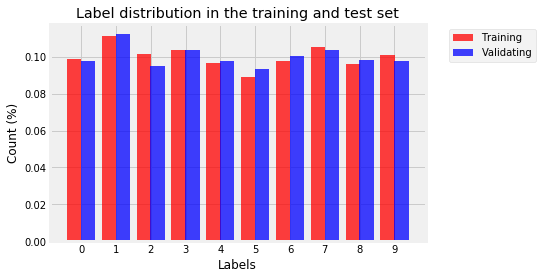

In [19]:
# number of label classes, 0 - 9
n_classes = 10

# look for imbalance in the sample observations for the class
training_counts = [None] * n_classes
validation_counts = [None] * n_classes

for i in range(n_classes):
    training_counts[i] = len(y_train[y_train == i])/len(y_train)
    validation_counts[i] = len(y_val[y_val == i])/len(y_val)

# plot histogram of the data
train_bar = plt.bar(np.arange(n_classes)-0.2, training_counts, align='center', color = 'r', alpha=0.75, width = 0.41, label='Training')
validate_bar = plt.bar(np.arange(n_classes)+0.2, validation_counts, align='center', color = 'b', alpha=0.75, width = 0.41, label = 'Validating')

plt.xlabel('Labels')
plt.xticks((0,1,2,3,4,5,6,7,8,9))
plt.ylabel('Count (%)')
plt.title('Label distribution in the training and test set')
plt.legend(bbox_to_anchor=(1.05, 1), handles=[train_bar, validate_bar], loc=2)
plt.grid(True)
plt.show()



<Figure size 756x504 with 0 Axes>

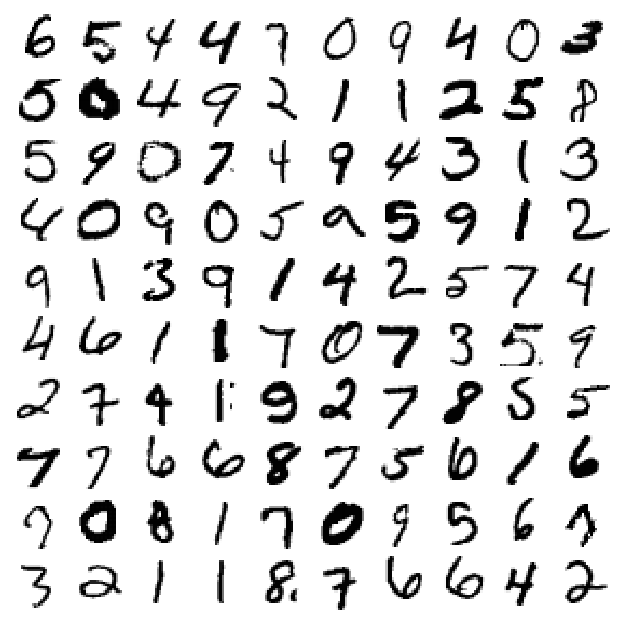

In [20]:
# plot a sample of the images being trained on
##set up the parameters
plt.figure(figsize=(10.5,7))
example_images = X_train[:100]
rt.plot_sample_images(example_images, images_per_row=10)
plt.savefig(f'{imageDir}explore_sample_images.png', dpi=300)
plt.show()

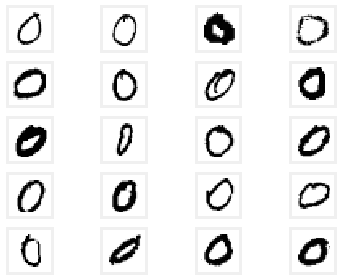

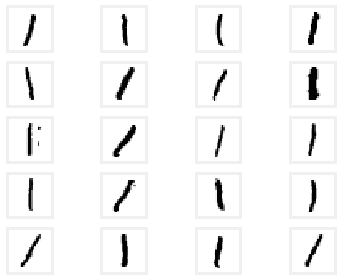

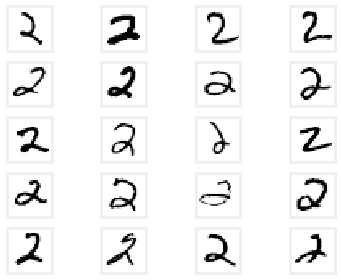

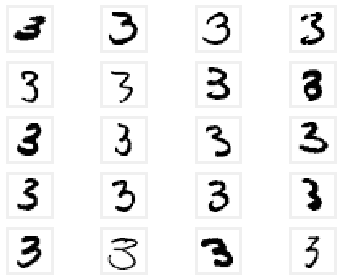

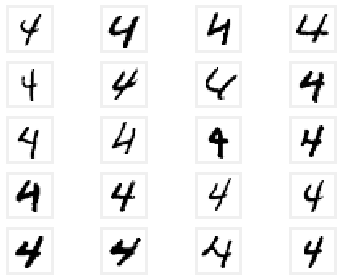

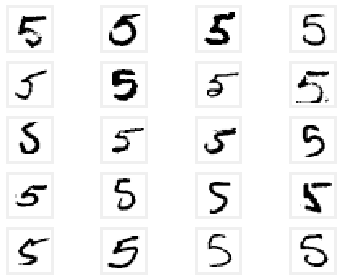

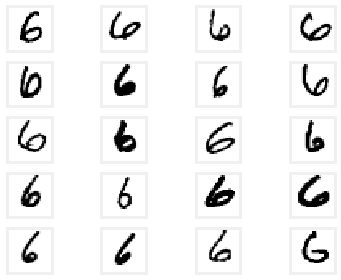

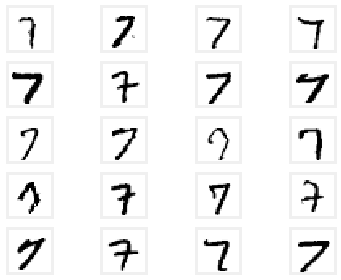

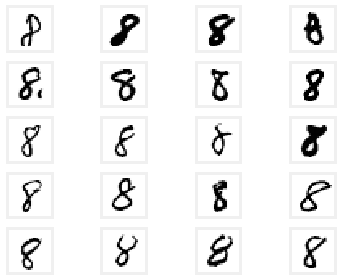

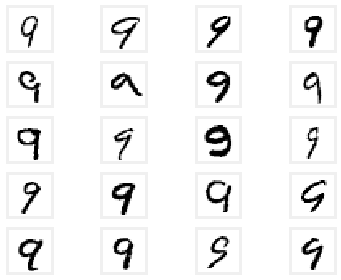

In [21]:
# look at differenct variations of the same image
#plt.figure(figsize=(10, 7.5))
imageName = 'class_images.png'
#imageType = 6
for i in range(num_classes):
    saveImage = f'{i}_{imageName}'
    rt.visualize_image_variations(X_train, y_train, i, 20, (28,28), f'{imageDir}{saveImage}.png')

Python package: [sklearn.preprocessing.LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)  

In [22]:
# normalize the data set to 0-to-1 range
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

# normalize inputs from RGB color to 0-1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

# one hot encoding
lbe = LabelEncoder()
y_train = lbe.fit_transform(y_train)
#y_train = y_train.astype('int32')
y_val = lbe.fit_transform(y_val).astype('int32')

# input shape
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [23]:
y_train

array([6, 5, 4, ..., 3, 3, 2], dtype=int64)

In [24]:
# setup dictionary object to capture model performance scorings

modelsPerformance = {'Name':[], 
                     'TestAccuracyScore':[],
                     'PredictAccuracyScore':[],
                     'FitTime':[], 
                     'ScoreTime':[], 
                     'PredictTime':[]
                    }

# create copy of training data to work on for model tuning
data = np.copy(X_train)
target = np.copy(y_train)

# 2. Support Vector Classification - SVMs
**-------------------------------------------------------------------------------------------------**   
Python Package: scikit-learn v0.21.3 [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)  

#### Modeling & Evaluation Functions

Python package [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)  

## 2.1 Model - Support Vector Classification
Python package:  


### 2.1.1 Create Base SVC model


In [25]:
# base SVC model
svc_base = SVC(C=1.0,                         # Penalty parameter C of the error term.
               cache_size=200,                # Specify the size of the kernel cache (in MB).
               class_weight=None,             # Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
               coef0=0.0,                     # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
               decision_function_shape='ovr', # Whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2). However, one-vs-one (‘ovo’) is always used as multi-class strategy.
               degree=3,                      # Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
               gamma='auto',                  # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. Current default is ‘auto’ which uses 1 / n_features, if gamma='scale' is passed then it uses 1 / (n_features * X.var()) as value of gamma.
               kernel='rbf',                  # Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable.
               max_iter=-1,                   # Hard limit on iterations within solver, or -1 for no limit.
               probability=False,             # Whether to enable probability estimates. This must be enabled prior to calling fit, and will slow down that method.
               random_state=None,             # The seed of the pseudo random number generator used when shuffling the data for probability estimates. If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
               shrinking=True,                # Whether to use the shrinking heuristic.
               tol=0.001,                     # Tolerance for stopping criterion.
               verbose=True                   # Enable verbose output. Note that this setting takes advantage of a per-process runtime setting in libsvm that, if enabled, may not work properly in a multithreaded context.
              )

In [26]:
# fit the svc model
t = 0.0
with rt.elapsed_timer() as elapsed:
    # 
    svc_fit = svc_base.fit(X_train, y_train)
    t = elapsed()
    if sh_logger.debug: print(f'Support Vector Classification Model Build Time: [{t}]')

modelsPerformance['Name'].append('svc_base')
modelsPerformance['FitTime'].append(t)

#save model to file
with open(modelBaselineDir+'svc_base','wb') as f:
    pickle.dump(svc_base,f)

with open(modelBaselineDir+'svc_fit','wb') as f:
    pickle.dump(svc_fit,f)

[LibSVM]Support Vector Classification Model Build Time: [234.36411890000002]


In [27]:
# Score the svc model
t = 0.0
with rt.elapsed_timer() as elapsed:
    svc_score =  svc_base.score(X_val, y_val)
    t = elapsed()
    if sh_logger.info: print(f'Support Vector Classification Model Fit Score: {[svc_score]}')
    if sh_logger.debug: print(f'Support Vector Classification Model Fit Score Time: [{t}]')

modelsPerformance['TestAccuracyScore'].append(svc_score)
modelsPerformance['ScoreTime'].append(t)

# save score to file
with open(modelBaselineDir+'svc_score','wb') as f:
    pickle.dump(svc_score,f)

Support Vector Classification Model Fit Score: [0.9354978354978355]
Support Vector Classification Model Fit Score Time: [149.54252509999998]


### 2.1.2 Fit Model Prediciton - SVC

In [28]:
#%%time
# predictions of test set split from training set
t = 0.0
with rt.elapsed_timer() as elapsed:
    svc_pred = svc_base.predict(X_val)
    t = elapsed()
    if sh_logger.debug: print(f'Support Vector Classification Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

# save score to file
with open(modelBaselineDir+'svc_pred','wb') as f:
    pickle.dump(svc_pred,f)

Support Vector Classification Predict Time: [151.98244820000008]


In [29]:
%%time
if sh_logger.debug: print(f'y_val size: {y_val.size} svc_pred size: {svc_pred.size}')

#correct and inccorrect
correct = np.nonzero(svc_pred==y_val)[0]
incorrect = np.nonzero(svc_pred!=y_val)[0]
    
d = {'Label':y_val, 'Prediction':svc_pred}
svcPredictionsDf = pd.DataFrame(data=d)
if sh_logger.debug: print(f'Support Vector Classification DF Shape: {svcPredictionsDf.shape}\n Head:\n{svcPredictionsDf.head()}')

# which test observations were miss classified
svc_missClassified_DT = svcPredictionsDf[(svcPredictionsDf['Label'] != svcPredictionsDf['Prediction'])]

if sh_logger.debug: print(f'Miss Classified DF Shape: {svc_missClassified_DT.shape}')
if sh_logger.debug: print(f'Miss Classified Percent: {svc_missClassified_DT.shape[0]/y_val.size}')
if sh_logger.info: print(f'Total Number of points: [{X_val.shape[0]}]  Mislabeled Points: [{(y_val != svc_pred).sum()}]')

y_val size: 13860 svc_pred size: 13860
Support Vector Classification DF Shape: (13860, 2)
 Head:
   Label  Prediction
0      4           4
1      3           3
2      2           2
3      4           4
4      2           2
Miss Classified DF Shape: (894, 2)
Miss Classified Percent: 0.0645021645021645
Total Number of points: [13860]  Mislabeled Points: [894]
Wall time: 6.98 ms


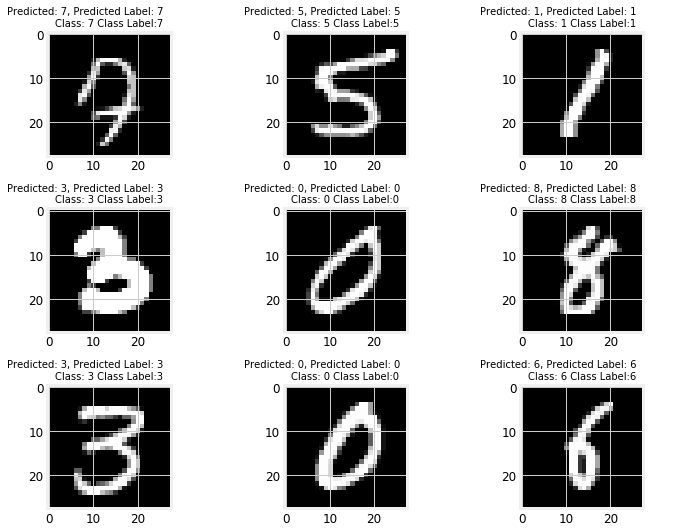

In [30]:
# sample plot of correctly predicted images
plt.figure(figsize=(10, 7.5))
for i, cor in enumerate(np.random.choice(correct,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_val[cor].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {svc_pred[cor]}, Predicted Label: {class_to_label[svc_pred[cor]]} \
              \nClass: {y_val[cor]} Class Label:{class_to_label[y_val[cor]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}svc_sample_correct_images.png', dpi=300)
plt.show() 

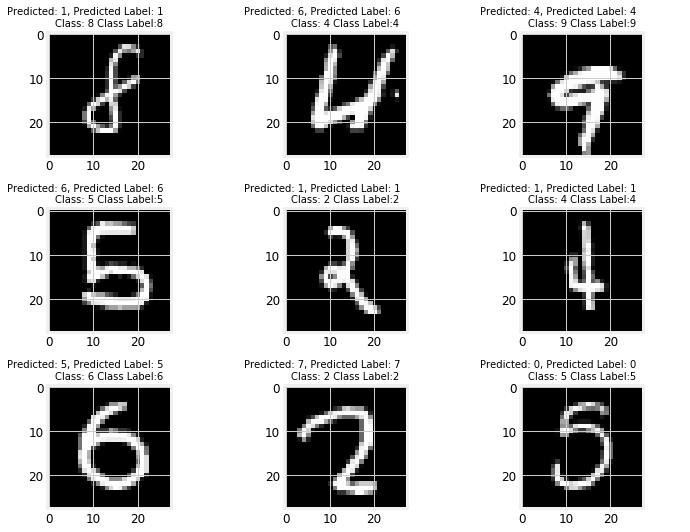

In [31]:
# plot sample of incorrect
plt.figure(figsize=(10, 7.5))
for i, inc in enumerate(np.random.choice(incorrect,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_val[inc].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {svc_pred[inc]}, Predicted Label: {class_to_label[svc_pred[inc]]} \
              \nClass: {y_val[inc]} Class Label:{class_to_label[y_val[inc]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}svc_sample_incorrect_images.png', dpi=300)
plt.show() 

### 2.1.3 Evaluate Model

Total Number of points: [13860]  Mislabeled Points: [894]
Percent Mislabeled: [0.0645021645021645]
Percent Accurately Labeled: [0.9354978354978355]

              precision    recall  f1-score   support

      Class0       0.96      0.98      0.97      1353
      Class1       0.94      0.98      0.96      1555
      Class2       0.93      0.92      0.92      1314
      Class3       0.92      0.90      0.91      1439
      Class4       0.93      0.94      0.94      1355
      Class5       0.90      0.91      0.90      1296
      Class6       0.95      0.97      0.96      1395
      Class7       0.96      0.94      0.95      1434
      Class8       0.93      0.90      0.92      1365
      Class9       0.92      0.91      0.91      1354

    accuracy                           0.94     13860
   macro avg       0.94      0.93      0.93     13860
weighted avg       0.94      0.94      0.94     13860


SVM Base Confusion Matrix Report:
[[1328    0    2    3    4    3    6    0    6    1]
 [  

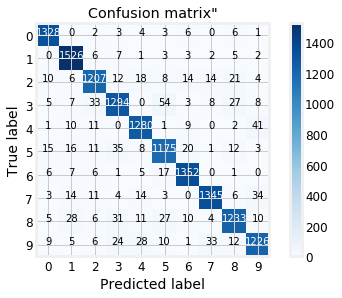

In [32]:
misLabeled = (y_val != svc_pred).sum()/X_val.shape[0]
svmAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_val.shape[0]}]  Mislabeled Points: [{(y_val != svc_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_val != svc_pred).sum()/X_val.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{svmAccuractelyLabeled}]')
    
modelsPerformance['PredictAccuracyScore'].append(svmAccuractelyLabeled)

#print classification report table
targetNames = ["Class{}".format(i) for i in range(n_classes)]
if sh_logger.info: print(f'\n{classification_report(y_val, svc_pred, target_names=targetNames)}')  

#print confusion matrix report
cm = confusion_matrix(y_val,svc_pred, labels=[0,1,2,3,4,5,6,7,8,9])
if sh_logger.info: print(f'\nSVM Base Confusion Matrix Report:\n{cm}')

# plot confusion matrix evaluation
if sh_logger.info: rt.plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

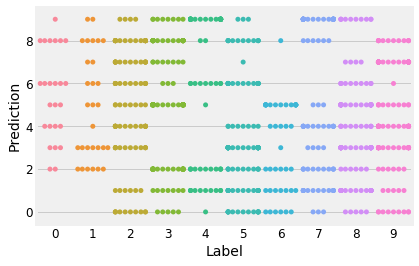

In [33]:
sns.swarmplot(x='Label',y='Prediction',data=svc_missClassified_DT);

### 2.1.4 Tune Model Performance
For more information on tuning an SVM classifier, go [here](https://scikit-learn.org/stable/modules/svm.html#svm-classification) for details.   
Tips:  
* Consider performing dimensionality reduction (PCA, ICA, or Feature selection) beforehand to give your tree a better chance of finding features that are discriminative.  
* Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant.  
* All decision trees use np.float32 arrays internally.  
* If the input matrix X is very sparse, it is recommended to convert to sparse csc_matrix before calling fit and sparse csr_matrix before calling predict. Training time can be orders of magnitude faster for a sparse matrix input compared to a dense matrix when features have zero values in most of the samples.   

In [34]:
# tune model

## 3. Model - RandomForestClassifier
-----------------------------------------------------------------------------
Python Package: scikit-learn v0.21.3 [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).  

### 3.1 Create Models - RandomForestClassifier
Cross-Validate at 3 folds...

In [37]:
# pre-process datasets

#### Random Forest Attributes
See scikit learn [glossary](https://scikit-learn.org/stable/glossary.html#term-warm-start) for indepth details.   

In [38]:
rf_base = RandomForestClassifier(n_estimators=100,             # The number of trees in the forest.
                                 criterion="gini",             # The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
                                 max_depth=None,               # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                                 min_samples_split=2,          # The minimum number of samples required to split an internal node
                                 min_samples_leaf=1,           # The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches
                                 min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
                                 max_features="auto",          # The number of features to consider when looking for the best split: If “auto”, then max_features=sqrt(n_features).
                                 max_leaf_nodes=None,          # Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                                 min_impurity_decrease=0.0,    # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                                 min_impurity_split=None,      # Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
                                 bootstrap=True,               # Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree
                                 oob_score=False,              # Whether to use out-of-bag samples to estimate the generalization accuracy.
                                 n_jobs=None,                  # The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 random_state=None,            # if int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random
                                 verbose=2,                    # Controls the verbosity when fitting and predicting.
                                 warm_start=False,             # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                                 class_weight=None             # Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
                                )


In [39]:
# fit the Random Forest model
t = 0.0
with rt.elapsed_timer() as elapsed:
    # 
    rf_base_fit = rf_base.fit(X_train, y_train)
    t = elapsed()
    if sh_logger.debug: print(f'Random Forest Classification Model Build Time: [{t}]')

modelsPerformance['Name'].append('rf_base')
modelsPerformance['FitTime'].append(t)

#save model to file
with open(modelBaselineDir+'rf_base','wb') as f:
    pickle.dump(rf_base,f)

with open(modelBaselineDir+'rf_base_fit','wb') as f:
    pickle.dump(rf_base_fit,f)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.0s finished


Random Forest Classification Model Build Time: [21.162543099999994]


In [88]:
rf_base.get_params(deep=True)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 2,
 'warm_start': False}

In [40]:
# Score the Random Forest model
t = 0.0
with rt.elapsed_timer() as elapsed:
    rf_base_score =  rf_base.score(X_val, y_val)
    t = elapsed()
    if sh_logger.info: print(f'Random Forest Base Classification Model Fit Score: {[rf_base_score]}')
    if sh_logger.debug: print(f'Random Forest Base Classification Model Fit Score Time: [{t}]')

modelsPerformance['TestAccuracyScore'].append(rf_base_score)
modelsPerformance['ScoreTime'].append(t)

# save score to file
with open(modelBaselineDir+'rf_base_score','wb') as f:
    pickle.dump(rf_base_score,f)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Random Forest Base Classification Model Fit Score: [0.9632756132756133]
Random Forest Base Classification Model Fit Score Time: [0.6793430000000171]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [41]:

modelsPerformance

{'Name': ['svc_base', 'rf_base'],
 'TestAccuracyScore': [0.9354978354978355, 0.9632756132756133],
 'PredictAccuracyScore': [0.9354978354978355],
 'FitTime': [234.36411890000002, 21.162543099999994],
 'ScoreTime': [149.54252509999998, 0.6793430000000171],
 'PredictTime': [151.98244820000008]}

### 3.2 Fit Model Prediction - Random Forest

In [42]:
%%time
# predictions of test set split from training set
t = 0.0
with rt.elapsed_timer() as elapsed:
    rf_base_pred = rf_base.predict(X_val)
    t = elapsed()
    if sh_logger.debug: print(f'Random Forest Base Classification Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

# save score to file
with open(modelBaselineDir+'rf_base_pred','wb') as f:
    pickle.dump(rf_base_pred,f)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Random Forest Base Classification Predict Time: [0.6819219999999859]
Wall time: 689 ms


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [43]:
%%time
if sh_logger.debug: print(f'y_val size: {y_val.size} rf_base_pred size: {rf_base_pred.size}')

#correct and inccorrect
correct = np.nonzero(rf_base_pred==y_val)[0]
incorrect = np.nonzero(rf_base_pred!=y_val)[0]
    
d = {'Label':y_val, 'Prediction':rf_base_pred}
rf_base_PredictionsDf = pd.DataFrame(data=d)
if sh_logger.debug: print(f'Random Forest Base Classification DF Shape: {rf_base_PredictionsDf.shape}\n Head:\n{rf_base_PredictionsDf.head()}')

# which test observations were miss classified
rf_base_missClassified_DT = rf_base_PredictionsDf[(rf_base_PredictionsDf['Label'] != rf_base_PredictionsDf['Prediction'])]

if sh_logger.debug: print(f'Miss Classified DF Shape: {rf_base_missClassified_DT.shape}')
if sh_logger.debug: print(f'Miss Classified Percent: {rf_base_missClassified_DT.shape[0]/y_val.size}')
if sh_logger.info: print(f'Total Number of points: [{X_val.shape[0]}]  Mislabeled Points: [{(y_val != rf_base_pred).sum()}]')

y_val size: 13860 rf_base_pred size: 13860
Random Forest Base Classification DF Shape: (13860, 2)
 Head:
   Label  Prediction
0      4           4
1      3           3
2      2           2
3      4           4
4      2           2
Miss Classified DF Shape: (509, 2)
Miss Classified Percent: 0.03672438672438672
Total Number of points: [13860]  Mislabeled Points: [509]
Wall time: 4.96 ms


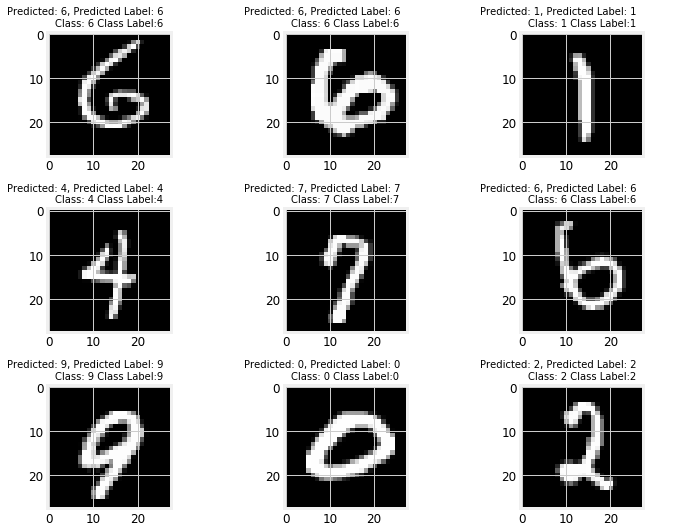

In [44]:
# sample plot of correctly predicted images
plt.figure(figsize=(10, 7.5))
for i, cor in enumerate(np.random.choice(correct,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_val[cor].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {rf_base_pred[cor]}, Predicted Label: {class_to_label[rf_base_pred[cor]]} \
              \nClass: {y_val[cor]} Class Label:{class_to_label[y_val[cor]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}rf_base_sample_correct_images.png', dpi=300)
plt.show() 

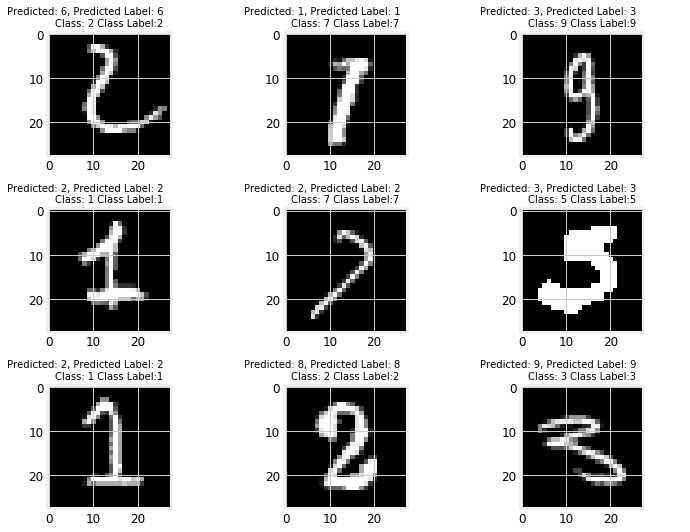

In [45]:
# plot sample of incorrect
plt.figure(figsize=(10, 7.5))
for i, inc in enumerate(np.random.choice(incorrect,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_val[inc].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {rf_base_pred[inc]}, Predicted Label: {class_to_label[rf_base_pred[inc]]} \
              \nClass: {y_val[inc]} Class Label:{class_to_label[y_val[inc]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}rf_base_sample_incorrect_images.png', dpi=300)
plt.show() 

### 3.3 Evaluate Model - Random Forest Base

Total Number of points: [13860]  Mislabeled Points: [509]
Percent Mislabeled: [0.03672438672438672]
Percent Accurately Labeled: [0.9632756132756133]

              precision    recall  f1-score   support

      Class0       0.97      0.99      0.98      1353
      Class1       0.98      0.98      0.98      1555
      Class2       0.95      0.96      0.96      1314
      Class3       0.95      0.94      0.95      1439
      Class4       0.97      0.97      0.97      1355
      Class5       0.97      0.95      0.96      1296
      Class6       0.97      0.98      0.98      1395
      Class7       0.97      0.96      0.97      1434
      Class8       0.95      0.95      0.95      1365
      Class9       0.95      0.94      0.95      1354

    accuracy                           0.96     13860
   macro avg       0.96      0.96      0.96     13860
weighted avg       0.96      0.96      0.96     13860


SVM Base Confusion Matrix Report:
[[1336    0    0    1    1    2    5    0    7    1]
 [ 

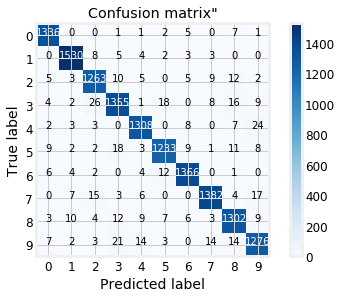

In [46]:
misLabeled = (y_val != rf_base_pred).sum()/X_val.shape[0]
rfBaseAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_val.shape[0]}]  Mislabeled Points: [{(y_val != rf_base_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_val != rf_base_pred).sum()/X_val.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{rfBaseAccuractelyLabeled}]')
    
modelsPerformance['PredictAccuracyScore'].append(rfBaseAccuractelyLabeled)

#print classification report table
targetNames = ["Class{}".format(i) for i in range(n_classes)]
if sh_logger.info: print(f'\n{classification_report(y_val, rf_base_pred, target_names=targetNames)}')  

#print confusion matrix report
cm = confusion_matrix(y_val,rf_base_pred, labels=[0,1,2,3,4,5,6,7,8,9])
if sh_logger.info: print(f'\nSVM Base Confusion Matrix Report:\n{cm}')

# plot confusion matrix evaluation
if sh_logger.info: rt.plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

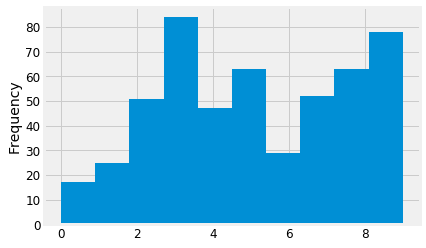

In [47]:
ax = rf_base_missClassified_DT['Label'].plot.hist(bins=10)

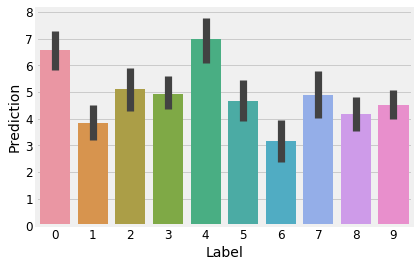

In [48]:
sns.barplot(x='Label',y='Prediction',data=rf_base_missClassified_DT);

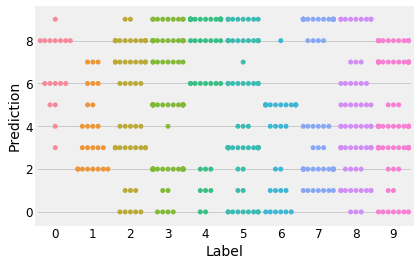

In [49]:
sns.swarmplot(x='Label',y='Prediction',data=rf_base_missClassified_DT);

### 3.4 Tune Models
For details on how to tune a Random Forest Classifier, go [here](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters) for details.  

In [50]:
# perform model creation and validation techniques

### 3.5 iNterpret Models
Interpret the model results, make knowledge based recommendations

In [52]:
# perform interpretation steps

# 4. K Neighbors Classifier
**-------------------------------------------------------------------------------------------------**   
Python Package: scikit-learn v0.21.3 [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)  


### 4.1 Explore
Explore the datasets

In [53]:
if sh_logger.debug: print(f'{data.shape} {target.shape}')
if sh_logger.debug: print(f'{data[1:10]} \n{target[1:10]}')

(28140, 784) (28140,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
[5 4 4 7 0 9 4 0 3]


## 4.2 Model
Create models

### 4.2.1 Create Base KNeighborsClassifier Model


In [54]:
modelsPerformance

{'Name': ['svc_base', 'rf_base'],
 'TestAccuracyScore': [0.9354978354978355, 0.9632756132756133],
 'PredictAccuracyScore': [0.9354978354978355, 0.9632756132756133],
 'FitTime': [234.36411890000002, 21.162543099999994],
 'ScoreTime': [149.54252509999998, 0.6793430000000171],
 'PredictTime': [151.98244820000008, 0.6819219999999859]}

In [55]:
# initialize base KNeighborsClassifier
kNN_base = KNeighborsClassifier(n_neighbors=5, 
                                weights="uniform",   # weight function used in prediction. ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
                                algorithm="auto",    # Algorithm used to compute the nearest neighbors - ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.
                                leaf_size=30,        # Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.
                                p=2,                 # Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
                                metric="minkowski",  # the distance metric to use for the tree. The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric.
                                metric_params=None,  # Additional keyword arguments for the metric function.
                                n_jobs=None)         # The number of parallel jobs to run for neighbors search. None means 1

In [56]:
# fit the kNN model
t = 0.0
with rt.elapsed_timer() as elapsed:
    # 
    kNN_fit = kNN_base.fit(X_train, y_train)
    t = elapsed()
    if sh_logger.debug: print(f'K-Nearest Neighbors Classification Model Build Time: [{t}]')

modelsPerformance['Name'].append('kNN_base')
modelsPerformance['FitTime'].append(t)

#save model to file
with open(modelBaselineDir+'kNN_base','wb') as f:
    pickle.dump(kNN_base,f)

with open(modelBaselineDir+'kNN_fit','wb') as f:
    pickle.dump(kNN_fit,f)

K-Nearest Neighbors Classification Model Build Time: [3.746577200000047]


In [57]:
# Score the kNN base model
t = 0.0
with rt.elapsed_timer() as elapsed:
    kNN_base_score =  kNN_base.score(X_val, y_val)
    t = elapsed()
    if sh_logger.info: print(f'K-Nearest Neighbors Classification Model Fit Score: {[kNN_base_score]}')
    if sh_logger.debug: print(f'K-Nearest Neighbors Classification Model Fit Score Time: [{t}]')

modelsPerformance['TestAccuracyScore'].append(kNN_base_score)
modelsPerformance['ScoreTime'].append(t)

# save score to file
with open(modelBaselineDir+'kNN_base_score','wb') as f:
    pickle.dump(kNN_base_score,f)

K-Nearest Neighbors Classification Model Fit Score: [0.9640692640692641]
K-Nearest Neighbors Classification Model Fit Score Time: [479.1274994999999]


In [82]:
kNN_base.get_params(deep=True)

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

### 4.2.2 Fit Model Prediction - kNN Base

In [58]:
#%%time
# predictions of test set split from training set
t = 0.0
with rt.elapsed_timer() as elapsed:
    kNN_base_pred = kNN_base.predict(X_val)
    t = elapsed()
    if sh_logger.debug: print(f'K-Nearest Neighbors Base Classification Model Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

# save score to file
with open(modelBaselineDir+'kNN_base_pred','wb') as f:
    pickle.dump(kNN_base_pred,f)

K-Nearest Neighbors Base Classification Model Predict Time: [471.4505531]


In [59]:
%%time
if sh_logger.debug: print(f'y_val size: {y_val.size} svc_pred size: {kNN_base_pred.size}')

#correct and inccorrect
correct = np.nonzero(kNN_base_pred==y_val)[0]
incorrect = np.nonzero(kNN_base_pred!=y_val)[0]
    
d = {'Label':y_val, 'Prediction':kNN_base_pred}
kNNPredictionsDf = pd.DataFrame(data=d)
if sh_logger.debug: print(f'K-Nearest Neighbors Classification Model DF Shape: {kNNPredictionsDf.shape}\n Head:\n{kNNPredictionsDf.head()}')

# which test observations were miss classified
kNN_missClassified_DT = kNNPredictionsDf[(kNNPredictionsDf['Label'] != kNNPredictionsDf['Prediction'])]

if sh_logger.debug: print(f'Miss Classified DF Shape: {kNN_missClassified_DT.shape}')
if sh_logger.debug: print(f'Miss Classified Percent: {kNN_missClassified_DT.shape[0]/y_val.size}')
if sh_logger.info: print(f'Total Number of points: [{X_val.shape[0]}]  Mislabeled Points: [{(y_val != kNN_base_pred).sum()}]')

y_val size: 13860 svc_pred size: 13860
K-Nearest Neighbors Classification Model DF Shape: (13860, 2)
 Head:
   Label  Prediction
0      4           4
1      3           3
2      2           2
3      4           4
4      2           2
Miss Classified DF Shape: (498, 2)
Miss Classified Percent: 0.03593073593073593
Total Number of points: [13860]  Mislabeled Points: [498]
Wall time: 5.99 ms


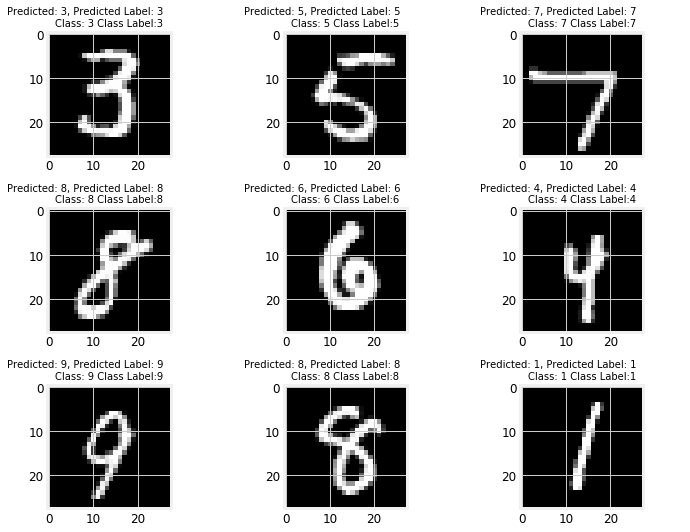

In [60]:
# sample plot of correctly predicted images
plt.figure(figsize=(10, 7.5))
for i, cor in enumerate(np.random.choice(correct,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_val[cor].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {kNN_base_pred[cor]}, Predicted Label: {class_to_label[kNN_base_pred[cor]]} \
              \nClass: {y_val[cor]} Class Label:{class_to_label[y_val[cor]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}kNN_base_sample_correct_images.png', dpi=300)
plt.show() 

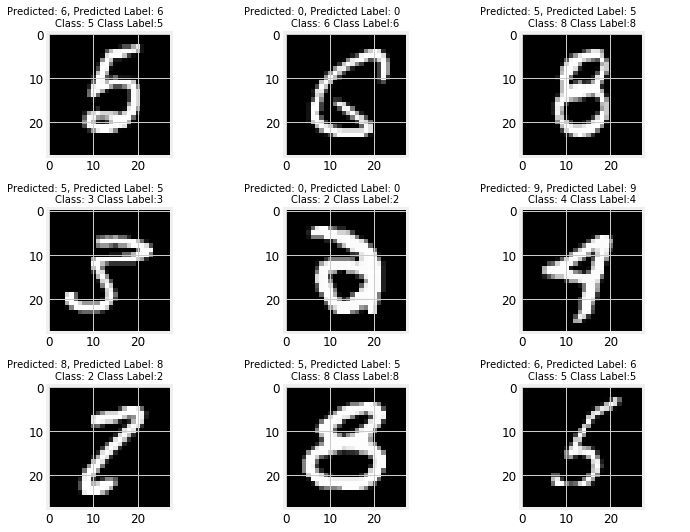

In [61]:
# plot sample of incorrect
plt.figure(figsize=(10, 7.5))
for i, inc in enumerate(np.random.choice(incorrect,9,replace=False)):
    # plot subplot of incorrect predictions
    plt.subplot(3,3,i+1)
    plt.imshow(X_val[inc].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(f'Predicted: {kNN_base_pred[inc]}, Predicted Label: {class_to_label[kNN_base_pred[inc]]} \
              \nClass: {y_val[inc]} Class Label:{class_to_label[y_val[inc]]}',
              fontsize=10)


plt.tight_layout()
plt.savefig(f'{imageDir}kNN_base_sample_incorrect_images.png', dpi=300)
plt.show() 

### 4.2.3 Evaluate Models - kNN Base

Total Number of points: [13860]  Mislabeled Points: [498]
Percent Mislabeled: [0.03593073593073593]
Percent Accurately Labeled: [0.9640692640692641]

              precision    recall  f1-score   support

      Class0       0.97      1.00      0.98      1353
      Class1       0.95      0.99      0.97      1555
      Class2       0.98      0.95      0.96      1314
      Class3       0.96      0.96      0.96      1439
      Class4       0.98      0.96      0.97      1355
      Class5       0.96      0.95      0.95      1296
      Class6       0.98      0.99      0.98      1395
      Class7       0.96      0.97      0.96      1434
      Class8       0.98      0.92      0.95      1365
      Class9       0.95      0.95      0.95      1354

    accuracy                           0.96     13860
   macro avg       0.96      0.96      0.96     13860
weighted avg       0.96      0.96      0.96     13860


K-Nearest Neighbors Base Classification:
[[1348    0    2    0    0    2    0    0    0   

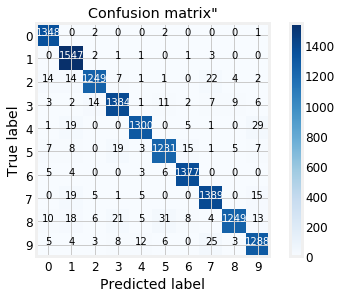

In [62]:
misLabeled = (y_val != kNN_base_pred).sum()/X_val.shape[0]
kNNAccuractelyLabeled = 1-misLabeled

if sh_logger.info: print(f'Total Number of points: [{X_val.shape[0]}]  Mislabeled Points: [{(y_val != kNN_base_pred).sum()}]')
if sh_logger.info: print(f'Percent Mislabeled: [{((y_val != kNN_base_pred).sum()/X_val.shape[0])}]')
if sh_logger.info: print(f'Percent Accurately Labeled: [{kNNAccuractelyLabeled}]')
    
modelsPerformance['PredictAccuracyScore'].append(kNNAccuractelyLabeled)

#print classification report table
targetNames = ["Class{}".format(i) for i in range(n_classes)]
if sh_logger.info: print(f'\n{classification_report(y_val, kNN_base_pred, target_names=targetNames)}')  

#print confusion matrix report
cm = confusion_matrix(y_val,kNN_base_pred, labels=[0,1,2,3,4,5,6,7,8,9])
if sh_logger.info: print(f'\nK-Nearest Neighbors Base Classification:\n{cm}')

# plot confusion matrix evaluation
if sh_logger.info: rt.plot_confusion_matrix(cm,classes=[0,1,2,3,4,5,6,7,8,9])

### 4.2.4 Tune Models

# 5. Algorithm Performance Comparison
**-------------------------------------------------------------------------------------------------**  
*Compare the results from the two algorithms. Which one reached higher accuracy? Which one runs faster? Can you explain why?*

In [63]:
# hw6 model performance results
# dtc, cnb, gnb - with cross fold validation
modelsPerformance['Name'].append('dtc_cv'); modelsPerformance['TestAccuracyScore'].append(0.843660); modelsPerformance['PredictAccuracyScore'].append(0.947403);modelsPerformance['FitTime'].append(9.689057); modelsPerformance['ScoreTime'].append(0.125913); modelsPerformance['PredictTime'].append(0.055994) 
modelsPerformance['Name'].append('cnb_cv'); modelsPerformance['TestAccuracyScore'].append(0.750096); modelsPerformance['PredictAccuracyScore'].append(0.717027);modelsPerformance['FitTime'].append(0.489532); modelsPerformance['ScoreTime'].append(0.141118); modelsPerformance['PredictTime'].append(0.082912) 
modelsPerformance['Name'].append('gnb_cv'); modelsPerformance['TestAccuracyScore'].append(0.674029); modelsPerformance['PredictAccuracyScore'].append(0.570924);modelsPerformance['FitTime'].append(0.902207); modelsPerformance['ScoreTime'].append(3.501948); modelsPerformance['PredictTime'].append(1.651511) 


In [72]:
# model accuracy of predicting labels, and compute time for mode build, score, predict
modelsPerf = pd.DataFrame(modelsPerformance)
modelsPerf['TotalTime'] = modelsPerf['FitTime']+modelsPerf['ScoreTime']+modelsPerf['PredictTime']
modelsPerf.to_csv(f'{dataDir}model_performence_matrix.csv', index=False)
modelsPerf.sort_values(by='PredictAccuracyScore', ascending=False)


,Name,TestAccuracyScore,PredictAccuracyScore,FitTime,ScoreTime,PredictTime,TotalTime
2,kNN_base,0.964069,0.964069,3.746577,479.127499,471.450553,954.324630
1,rf_base,0.963276,0.963276,21.162543,0.679343,0.681922,22.523808
3,dtc_cv,0.843660,0.947403,9.689057,0.125913,0.055994,9.870964
0,svc_base,0.935498,0.935498,234.364119,149.542525,151.982448,535.889092
4,cnb_cv,0.750096,0.717027,0.489532,0.141118,0.082912,0.713562
5,gnb_cv,0.674029,0.570924,0.902207,3.501948,1.651511,6.055666


In [74]:
modelsPerf.sort_values(by=['TotalTime'], ascending=True)

,Name,TestAccuracyScore,PredictAccuracyScore,FitTime,ScoreTime,PredictTime,TotalTime
4,cnb_cv,0.750096,0.717027,0.489532,0.141118,0.082912,0.713562
5,gnb_cv,0.674029,0.570924,0.902207,3.501948,1.651511,6.055666
3,dtc_cv,0.843660,0.947403,9.689057,0.125913,0.055994,9.870964
1,rf_base,0.963276,0.963276,21.162543,0.679343,0.681922,22.523808
0,svc_base,0.935498,0.935498,234.364119,149.542525,151.982448,535.889092
2,kNN_base,0.964069,0.964069,3.746577,479.127499,471.450553,954.324630


In [86]:
# Evaluating the classifiers with a VotingClassifier

from itertools import product
from sklearn.ensemble import VotingClassifier
estimators = [('kNN', kNN_fit), ('rf', rf_base_fit),('svc', svc_fit)]
eclf = VotingClassifier(
                        estimators=estimators,
                        voting='hard', 
                        weights=None,
                        n_jobs=None,
                        flatten_transform=True
                        )

eclf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.0s finished


[LibSVM]

VotingClassifier(estimators=[('kNN',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_

In [90]:
# Plotting decision regions
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
'''
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))


for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [kNN_fit, rf_base_fit, svc_fit, eclf],
                        ['KNN (k=5)', 'Random Forest (forests=100)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X_train[:, 0], X_train[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()
'''

"\nf, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))\n\n\nfor idx, clf, tt in zip(product([0, 1], [0, 1]),\n                        [kNN_fit, rf_base_fit, svc_fit, eclf],\n                        ['KNN (k=5)', 'Random Forest (forests=100)',\n                         'Kernel SVM', 'Soft Voting']):\n\n    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])\n    Z = Z.reshape(xx.shape)\n\n    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)\n    axarr[idx[0], idx[1]].scatter(X_train[:, 0], X_train[:, 1], c=y,\n                                  s=20, edgecolor='k')\n    axarr[idx[0], idx[1]].set_title(tt)\n\nplt.show()\n"

# 5. Kaggle Test Results
**-------------------------------------------------------------------------------------------------**
### 5.1 Submission File Format
The submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit predicted. For example, if predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then the submission file would look like:  

ImageId,Label  
1,3  
2,7  
3,8   
(27997 more lines)  

The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that, all but 3% of the images have been correctly classified.  


In [77]:
%%time
# predictions of unseen test set for submission
t = 0.0
with rt.elapsed_timer() as elapsed:
    kNN_base_submit_pred = kNN_base.predict(X_test)
    t = elapsed()
    if sh_logger.debug: print(f'kNN Model Predict Time, Unseen Submission Testset: [{t}]')

kNN Model Predict Time, Unseen Submission Testset: [1106.7902508999996]
Wall time: 18min 26s


In [80]:
if sh_logger.debug: print(f'kNN Classification Submission Test size: {kNN_base_submit_pred.size}')
    
sPred = pd.DataFrame(X_test)
#sub_predictions[1:40]
sample_sub['Label'] = kNN_base_submit_pred
sample_sub.to_csv(f'{outputDir}kNN_submission.csv', index=False)
sample_sub.head(10)

kNN Classification Submission Test size: 28000


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
